### FOLLOWED: [Blog link](https://analyticsindiamag.com/guide-to-sentiment-analysis-using-bert/)
- [Colab Repo](https://colab.research.google.com/drive/1atPVaDV02AIhr26nbNKVcX-9sLB5mOPu#scrollTo=xm8xlPqLmIYG)
## `Joined all data ---------------------------------------`

In [1]:
import pandas as pd

#### sample csv

In [2]:
data = pd.read_csv(r'D:\Celebel_Tech\files\1.csv').iloc[:,1:]
data.shape

(18, 2)

In [3]:
import pandas as pd
import glob
import os
  
# merging the files
joined_files = os.path.join(r"D:\Celebel_Tech\files\\", "*.csv")
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
  
# Finally, the files are joined
data_all = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
data_all.shape

(594, 4)

In [4]:
data_all.drop(['Tag','Unnamed: 0'],axis=1,inplace=True)

In [5]:
data_all.head()

,sentence,tag
0,"Welcome to celebal tech,IVR automation demo.",Neutral
1,"Hello. Hi, how are you?",Neutral
2,"I'm fine. Thank you for calling CT,Health insu...",Positive
3,I have an health policy with you. I wanted to ...,Neutral
4,"Of course I can do that,Could you please confi...",Neutral


In [6]:
data_all.tail()

,sentence,tag
589,That's no issue.,Positive
590,You have unlocked a special credit card upgrad...,Positive
591,"Yes, I want the credit limit,Upgraded.",Positive
592,"Congratulations, your credit limit is upgraded...",Positive
593,Thank you.,Positive


In [7]:
data_all.tag.value_counts()

Neutral     263
Positive    245
Negative     55
Neutal       14
positive      1
Name: tag, dtype: int64

## `Cleaning -----------------------------------------`

In [8]:
data_all = data_all.replace('positive','Positive')

In [9]:
data_all = data_all.replace('Neutal','Neutral')

In [10]:
data_all.tag.value_counts()

Neutral     277
Positive    246
Negative     55
Name: tag, dtype: int64

In [11]:
data_all.to_csv('complete.csv')

# `Distribution`

<AxesSubplot:xlabel='tag', ylabel='count'>

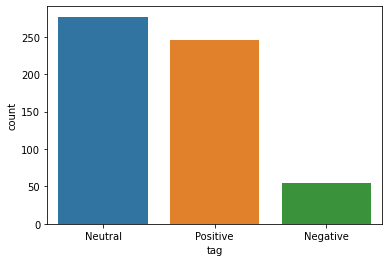

In [12]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.countplot(data_all.tag)

### `In Percentages`

In [13]:
data_all.shape[0]/3

198.0

In [14]:
data_all['tag'].value_counts()

Neutral     277
Positive    246
Negative     55
Name: tag, dtype: int64

In [15]:
data_all['tag'].value_counts()/data_all.shape[0]

Neutral     0.466330
Positive    0.414141
Negative    0.092593
Name: tag, dtype: float64

## `Sample modelling ------------------------------------------`

In [16]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cpu')

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### sample trial

In [18]:
sample_txt = 'Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.'

In [19]:
tokens = tokenizer.tokenize(sample_txt)

In [20]:
print(tokens)

['Best', 'place', 'that', 'I', 'have', 'visited', '?', 'Iceland', 'was', 'the', 'most', 'beautiful', 'and', 'I', 'consider', 'myself', 'lucky', 'to', 'have', 'visited', 'Iceland', 'at', 'such', 'an', 'early', 'age', '.']


In [21]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'  Sentence: {sample_txt}')
print(f'\n  Tokens: {tokens}')
print(f'\n  Token IDs: {token_ids}')

  Sentence: Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.

  Tokens: ['Best', 'place', 'that', 'I', 'have', 'visited', '?', 'Iceland', 'was', 'the', 'most', 'beautiful', 'and', 'I', 'consider', 'myself', 'lucky', 'to', 'have', 'visited', 'Iceland', 'at', 'such', 'an', 'early', 'age', '.']

  Token IDs: [1798, 1282, 1115, 146, 1138, 3891, 136, 10271, 1108, 1103, 1211, 2712, 1105, 146, 4615, 1991, 6918, 1106, 1138, 3891, 10271, 1120, 1216, 1126, 1346, 1425, 119]


## `Tokenization`
- Here we will initialise the special tokens required at the start and end of each sequence. We also need to add padding to make sure each sequence has the same length. By plotting a plot, we can check how are the data points in our dataset, when converted to tokens, show their length. 

In [22]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [23]:
encoding_test = tokenizer.encode_plus(
  sample_txt,
  max_length=32,           # sequence length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors(use tf for tensorflow and keras)
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
encoding_test

{'input_ids': tensor([[  101,  1798,  1282,  1115,   146,  1138,  3891,   136, 10271,  1108,
          1103,  1211,  2712,  1105,   146,  4615,  1991,  6918,  1106,  1138,
          3891, 10271,  1120,  1216,  1126,  1346,  1425,   119,   102,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0]])}

In [25]:
encoding_test.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
print(' length of the first sequence is :  ', len(encoding_test['input_ids'][0]))
print('\n The input id\'s are : \n', encoding_test['input_ids'][0])
print('\n The attention mask generated is : ', encoding_test['attention_mask'][0])

 length of the first sequence is :   32

 The input id's are : 
 tensor([  101,  1798,  1282,  1115,   146,  1138,  3891,   136, 10271,  1108,
         1103,  1211,  2712,  1105,   146,  4615,  1991,  6918,  1106,  1138,
         3891, 10271,  1120,  1216,  1126,  1346,  1425,   119,   102,     0,
            0,     0])

 The attention mask generated is :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0])


In [27]:
tokenizer.convert_ids_to_tokens(encoding_test['input_ids'].flatten())

['[CLS]',
 'Best',
 'place',
 'that',
 'I',
 'have',
 'visited',
 '?',
 'Iceland',
 'was',
 'the',
 'most',
 'beautiful',
 'and',
 'I',
 'consider',
 'myself',
 'lucky',
 'to',
 'have',
 'visited',
 'Iceland',
 'at',
 'such',
 'an',
 'early',
 'age',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# `------------------------------------------`
# `Modelling -------------------------------------------`
## `Modelling with our data`
# `------------------------------------------`

In [28]:
def group_sentiment(rating):
    if rating == 'Positive':
        return 2        
    elif rating == 'Neutral':
        return 1         
    else: 
        return 0        

In [29]:
data_all['tag'] = data_all.tag.apply(group_sentiment)

In [30]:
data_all.head(10)

,sentence,tag
0,"Welcome to celebal tech,IVR automation demo.",1
1,"Hello. Hi, how are you?",1
2,"I'm fine. Thank you for calling CT,Health insu...",2
3,I have an health policy with you. I wanted to ...,1
4,"Of course I can do that,Could you please confi...",1
5,"Yeah, sure, my mobile number is 9996668887.",2
6,I can confirm that you have active health insu...,2
7,Sure. My name is Manoj and my date of birth is...,2
8,"Thanks for confirmation,I can see that your po...",2
9,"I want to go for two,year option.",2


In [31]:
# data_all.loc[data_all.sentence.isnull()]

In [32]:
# data = data_all[data_all.sentence.notna()]
# data.head()

In [33]:
data_all.shape

(594, 2)

In [34]:
data = data_all

In [35]:
token_lens = []
for text in data.sentence:
    tokens_data = tokenizer.encode(text, max_length=512)   # Max possible length for the BERT model.
    token_lens.append(len(tokens_data))

In [36]:
token_lens

[14,
 10,
 31,
 23,
 33,
 20,
 28,
 20,
 60,
 12,
 18,
 6,
 13,
 16,
 17,
 12,
 19,
 5,
 19,
 4,
 38,
 9,
 57,
 8,
 30,
 12,
 31,
 13,
 30,
 8,
 16,
 9,
 35,
 6,
 25,
 7,
 35,
 14,
 39,
 9,
 74,
 14,
 60,
 6,
 53,
 7,
 55,
 12,
 26,
 4,
 13,
 10,
 19,
 10,
 20,
 6,
 33,
 5,
 19,
 4,
 39,
 6,
 62,
 8,
 10,
 11,
 12,
 8,
 33,
 7,
 14,
 11,
 4,
 16,
 11,
 6,
 11,
 30,
 6,
 31,
 12,
 12,
 10,
 9,
 25,
 15,
 28,
 7,
 4,
 10,
 28,
 5,
 19,
 4,
 39,
 6,
 55,
 8,
 25,
 14,
 40,
 13,
 16,
 24,
 18,
 49,
 17,
 21,
 4,
 37,
 13,
 14,
 23,
 4,
 27,
 6,
 42,
 4,
 51,
 12,
 32,
 15,
 34,
 6,
 39,
 9,
 33,
 14,
 41,
 15,
 40,
 9,
 76,
 10,
 19,
 10,
 29,
 9,
 77,
 12,
 21,
 9,
 13,
 10,
 19,
 10,
 70,
 4,
 42,
 4,
 41,
 11,
 42,
 19,
 15,
 15,
 8,
 28,
 26,
 29,
 18,
 30,
 21,
 43,
 13,
 19,
 6,
 13,
 10,
 17,
 12,
 20,
 5,
 26,
 4,
 26,
 7,
 41,
 6,
 38,
 11,
 32,
 16,
 28,
 13,
 17,
 5,
 27,
 4,
 34,
 12,
 10,
 6,
 13,
 7,
 13,
 13,
 17,
 8,
 12,
 16,
 26,
 5,
 17,
 6,
 24,
 12,
 27,
 17,
 18,
 20,

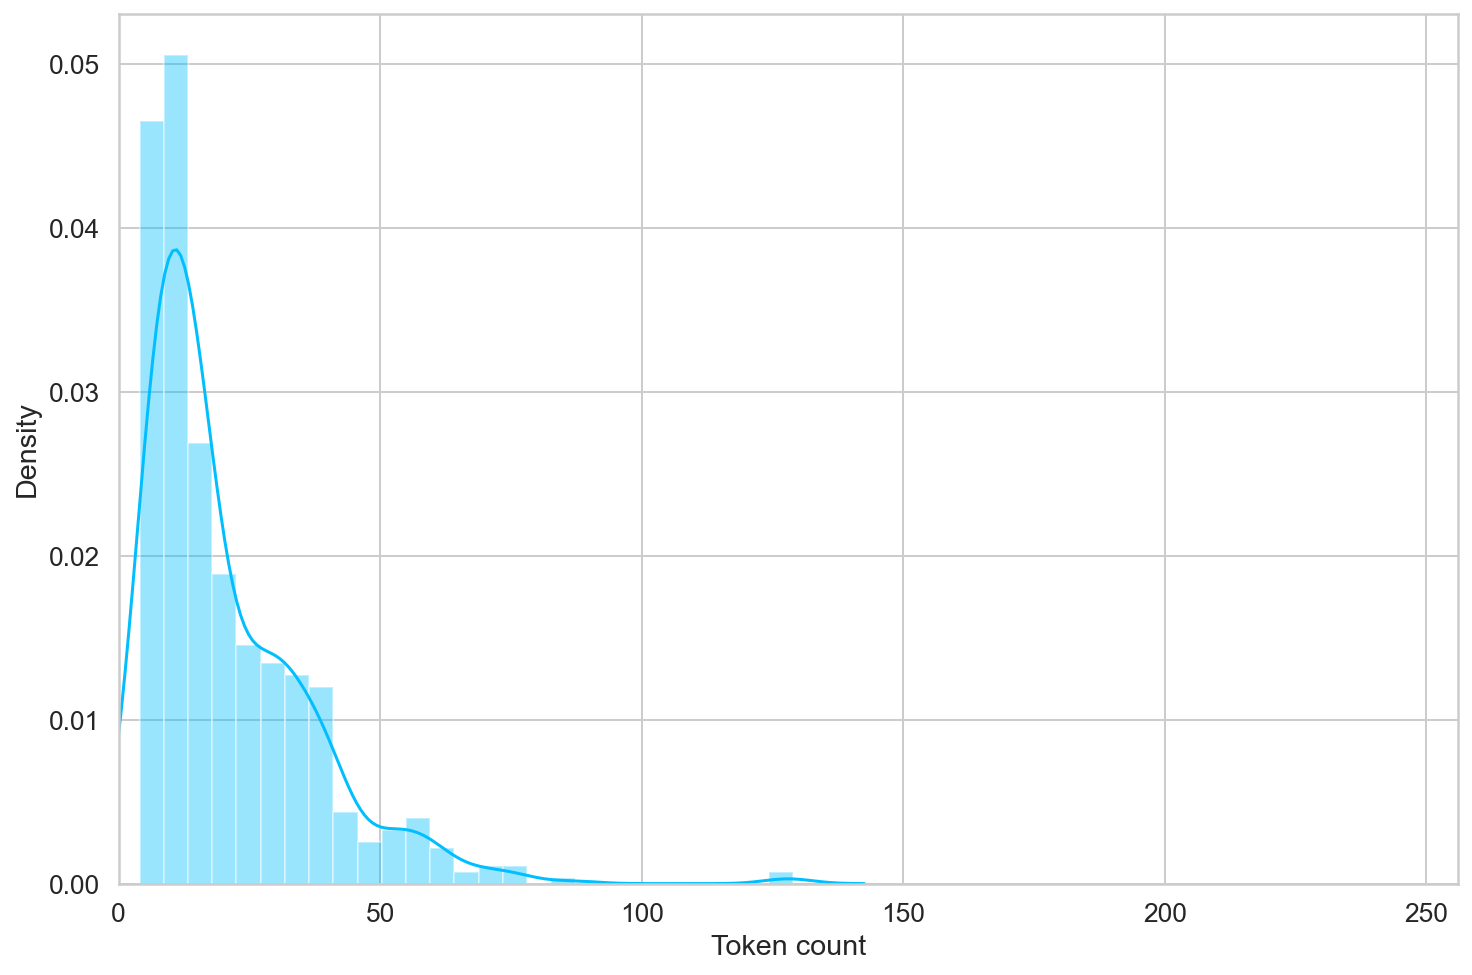

In [37]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [38]:
MAX_LEN = 150

## `Pytorch Dataset`

In [39]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews         # Reviews is content column.
        self.targets = targets         # Target is the sentiment column.
        self.tokenizer = tokenizer     # Tokenizer is the BERT_Tokanizer.
        self.max_len = max_len         # max_length of each sequence.

    def __len__(self):
        return len(self.reviews)       # Len of each review.
  
    def __getitem__(self, item):
        review = str(self.reviews[item])   # returns the string of reviews at the index = 'items'
        target = self.targets[item]        # returns the string of targets at the index = 'items'

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,                                   
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)            # dictionary containing all the features is returned.
        }

# `NLP Aug`: Data Augmentation
- [Click Here](https://www.analyticsvidhya.com/blog/2021/08/nlpaug-a-python-library-to-augment-your-text-data/)
- [CLick Here](https://towardsdatascience.com/powerful-text-augmentation-using-nlpaug-5851099b4e97)

In [40]:
#!pip install nlpaug

In [41]:
data_all.dtypes

sentence    object
tag          int64
dtype: object

In [42]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
import nlpaug
import nlpaug.augmenter.word as naw

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\manuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\manuj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [43]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
aug.augment("Misleading reviews. Worst coffee ever had, and sorely disappointing vibe.",n=3)

['Misleading reviews. Worst coffee berry ever had, and painfully disappointing vibe.',
 'Misleading reviews. Worst coffee always sustain, and sorely unsatisfying vibe.',
 'Lead astray reviews. Worst coffee tree ever had, and sorely disappointing vibe.']

In [44]:
data_neg = data_all[data_all.loc[:,'tag'] == 0]

In [45]:
len(data_neg)

71

In [46]:
data_neg.head()

,sentence,tag
13,I have a doubt. Will this policy cover my fami...,0
23,"No, not this one.",0
27,I didn't get you. Can you repeat?,0
29,Hold on for a second.,0
41,"What will happen,If I preclose this EMI.",0


In [47]:
lists = []
aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)
for i in data_neg.sentence:
    lists.append(aug.augment(i,n=3))

# `Augmentation -----------------------------------------`

In [48]:
sent = []
for i in lists:
    for j in i:
        sent.append(j)

In [49]:
len(sent)

213

In [50]:
sent

['I have a question. Will this insurance track my family equally intimately?',
 'One take a doubt. Will this insurance policy cover my family every bit advantageously?',
 'One have a doubt. Testament this insurance policy encompass my family as intimately?',
 'No, non this unity.',
 'No, non this i.',
 'No, non this 1.',
 "I didn ' t get you. Rear you repeat?",
 "1 didn ' t get you. Can you iterate?",
 "I didn ' t get you. Bottom you repeat?",
 'Hold on for a 2d.',
 'Hold on for a 2nd.',
 'Confine on for a second.',
 'What bequeath happen, If One preclose this EMI.',
 'What volition bump, If I preclose this EMI.',
 'What will happen, If One preclose this EMI.',
 'Bathroom you recapitulate again?',
 'Posterior you repeat again?',
 'Can you repeat once more?',
 'But you evidence maine not to portion any details.',
 'But you told me non to share any point.',
 'Simply you told me not to share any point.',
 'Iodin need a loan instead.',
 'One desire a loan instead.',
 'Ane want a loan alter

In [51]:
data_all.head()

,sentence,tag
0,"Welcome to celebal tech,IVR automation demo.",1
1,"Hello. Hi, how are you?",1
2,"I'm fine. Thank you for calling CT,Health insu...",2
3,I have an health policy with you. I wanted to ...,1
4,"Of course I can do that,Could you please confi...",1


In [52]:
sent[0]

'I have a question. Will this insurance track my family equally intimately?'

In [53]:
dataneg = pd.DataFrame(data=sent,columns=['sentence'])

In [54]:
dataneg['tag'] = 0
dataneg.head()

,sentence,tag
0,I have a question. Will this insurance track m...,0
1,One take a doubt. Will this insurance policy c...,0
2,One have a doubt. Testament this insurance pol...,0
3,"No, non this unity.",0
4,"No, non this i.",0


In [55]:
merged = pd.concat([data_all, dataneg])
merged.shape

(807, 2)

In [56]:
merged['tag'].value_counts()/merged.shape[0]

0    0.351921
1    0.343247
2    0.304833
Name: tag, dtype: float64

In [57]:
merged.to_csv('merged.csv')

In [58]:
data = merged

<AxesSubplot:xlabel='tag', ylabel='count'>

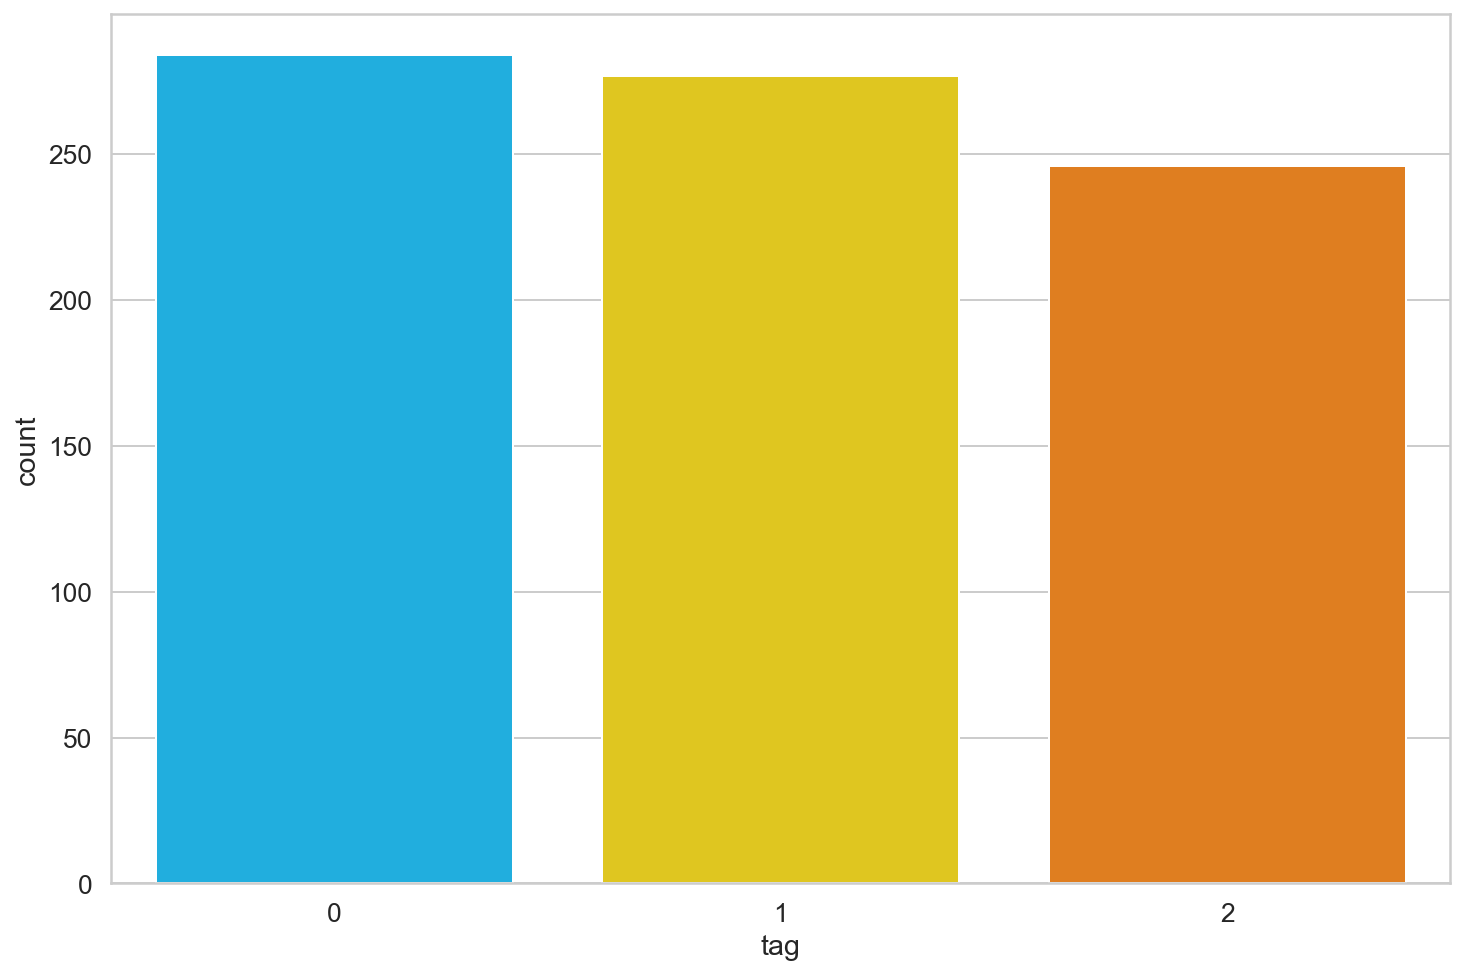

In [59]:
sns.countplot(merged.tag)

In [60]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [61]:
df_train.shape, df_val.shape, df_test.shape

((645, 2), (81, 2), (81, 2))

## `Data-Loaders`

In [62]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=data.sentence.values,
        targets=data.tag.values,
        tokenizer=tokenizer,
        max_len=max_len
  )                                  # Dataset would be created which can be used to create and return dataloader.

    return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4
  )

In [63]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [64]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [65]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 150])
torch.Size([8, 150])
torch.Size([8])


## `Sentiment Classification with BERT and Hugging Face`

In [66]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
model_test = bert_model(
  input_ids=encoding_test['input_ids'], 
  attention_mask=encoding_test['attention_mask']
)
model_test.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [68]:
last_hidden_state=model_test['last_hidden_state']
pooled_output=model_test['pooler_output']

In [69]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [70]:
bert_model.config.hidden_size

768

In [71]:
pooled_output.shape

torch.Size([1, 768])

# `---------------------------------------------------------------`
# `Model Building and Training ----------------------`
# `---------------------------------------------------------------`

In [72]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)                                 ## For regularization with dropout probability 0.3.
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) ## append an Output fully connected layer representing the number of classes

    def forward(self, input_ids, attention_mask):
        returned = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = returned["pooler_output"]
        output = self.drop(pooled_output)
        return self.out(output)

In [73]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 150])
torch.Size([8, 150])


In [75]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2004, 0.4055, 0.3941],
        [0.1985, 0.3327, 0.4688],
        [0.3624, 0.2897, 0.3480],
        [0.3439, 0.2798, 0.3764],
        [0.2954, 0.4239, 0.2807],
        [0.2119, 0.4038, 0.3843],
        [0.3386, 0.2291, 0.4323],
        [0.2181, 0.2058, 0.5761]], grad_fn=<SoftmaxBackward0>)

In [76]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS    # Number of batches * Epochs (Required for the scheduler.)
 
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,     # Recommended in the BERT paper.
  num_training_steps=total_steps  
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [77]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()    # To make sure that the droupout and normalization is enabled during the training.

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    max_prob, preds = torch.max(outputs, dim=1)    # Returns 2 tensors, one with max_probability and another with the respective predicted label.
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()     # Back_Propogation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Recommended by the BERT paper to clip the gradients to avoid exploding gradients.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)     # Return the mean loss and the ratio of correct predictions.

In [78]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()        # To make sure that the droupout and normalization is disabled during the training.

  losses = []
  correct_predictions = 0

  with torch.no_grad():        # Back propogation is not required. Torch would perform faster. 
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      max_prob, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [79]:
%%time

history = defaultdict(list)          # Similar to Keras library saves history
best_accuracy = 0                    

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.7134970826728473 accuracy 0.8465116279069768
Val   loss 4.52144694420864 accuracy 3.6049382716049383

Epoch 2/3
----------


KeyboardInterrupt: 

# `--------------------------------------------------------`
# `Prediction ----------------------------------------`
# `--------------------------------------------------------`

In [80]:
def predict(text):
    review_text = text
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    class_names = ['negative', 'neutral', 'positive']
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    print(prediction)

    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [81]:
predict('Hello. Hi, how are you?')

tensor([2])
Review text: Hello. Hi, how are you?
Sentiment  : positive


In [82]:
predict('That\'s no issue')

tensor([2])
Review text: That's no issue
Sentiment  : positive


## `Negative`

In [83]:
merged[merged.tag == 0][:5]

,sentence,tag
13,I have a doubt. Will this policy cover my fami...,0
23,"No, not this one.",0
27,I didn't get you. Can you repeat?,0
29,Hold on for a second.,0
41,"What will happen,If I preclose this EMI.",0


In [84]:
predict('No, not this one')

tensor([2])
Review text: No, not this one
Sentiment  : positive


In [85]:
predict('I didn\'t get you. Can you repeat?')

tensor([2])
Review text: I didn't get you. Can you repeat?
Sentiment  : positive


In [86]:
predict('Hold on for a second.')

tensor([2])
Review text: Hold on for a second.
Sentiment  : positive


## `Positive`

In [87]:
merged[merged.tag == 2].sample(5)

,sentence,tag
76,Thanks for confirming your name Manoj.,2
17,Thank you.,2
466,"It's OK,'s fine.",2
210,"Yes, my name is Manoj, and my date of birth is...",2
403,"Hello, everyone. Celebal technologies power th...",2


In [88]:
predict('Thank you')

tensor([1])
Review text: Thank you
Sentiment  : neutral


In [89]:
predict('It\'s OK,\'s fine')

tensor([1])
Review text: It's OK,'s fine
Sentiment  : neutral


In [90]:
predict('Thanks for confirming your name Manoj')

tensor([2])
Review text: Thanks for confirming your name Manoj
Sentiment  : positive


## `Neutral`

In [91]:
merged[merged.tag == 1].sample(5)

,sentence,tag
508,"OK, I can also see a transaction of 32,000 don...",1
164,I want to go for a two-year plan.,1
104,"I want to,Upgrade my,Online transaction limit ...",1
206,I want to know more about my Insurance policy.,1
245,This call is being recorded by a celebal tech ...,1


In [92]:
predict('I want to know more about my Insurance policy.')

tensor([2])
Review text: I want to know more about my Insurance policy.
Sentiment  : positive


In [93]:
predict('I want to go for a two-year plan')

tensor([2])
Review text: I want to go for a two-year plan
Sentiment  : positive


In [94]:
predict('So should I proceed?')

tensor([2])
Review text: So should I proceed?
Sentiment  : positive


In [95]:
predict('How much money will you need for this loan?')

tensor([2])
Review text: How much money will you need for this loan?
Sentiment  : positive


In [96]:
predict('What is,Tenure period.')

tensor([2])
Review text: What is,Tenure period.
Sentiment  : positive


# NOTE: `Needs more epoch training, atleast 10`